# FSM

## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
raw_df = pd.read_csv('../data/archive/1429_1.csv')
    
df = raw_df[['asins', 'reviews.rating', 'reviews.doRecommend', 'reviews.title', 'reviews.text']]
    
df.dropna(inplace=True)

/Users/adamroth/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/adamroth/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [4]:
df.sample(3)

,asins,reviews.rating,reviews.doRecommend,reviews.title,reviews.text
4607,B018Y229OU,4.0,True,Fun mini tablet,Good to have for smaller tablet use. Lightweig...
15154,B018Y225IA,5.0,True,Very durable!,This is the 3rd one I've purchased. I've bough...
33094,B00U3FPN4U,5.0,True,Great alternative to CABLE,I was tired of my cable bill being so high so ...


## Cleaning

In [5]:
sw = stopwords.words('english')

In [6]:
#from last NLP project, written with Amanda Potter 
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [7]:
#from last NLP project, written with Amanda Potter 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
  

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [8]:
X = df['reviews.text']
y = df['reviews.doRecommend']
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, test_size=.15)

In [9]:
X_train_dp = [doc_preparer(doc, sw) for doc in X_train]

In [10]:
print(type(X_train_dp))
X_train_dp[0]

<class 'list'>


'told fire stick tv friend go best buy store buy one store order one hand two day enjoy use everyday'

I'm seeing words like 'go' which will likely not be of any signifigance, I'll need to do an analysis of the word counts later on before making a 'better model'

In [11]:
X_t, X_val, y_t, y_val = train_test_split(X_train_dp, y_train, random_state=12, test_size=.20)

In [12]:
cv = CountVectorizer()

X_t_cv = cv.fit_transform(X_t)
#X_t_cv = pd.DataFrame.sparse.from_spmatrix(X_t_cv)
#X_t_cv.columns = sorted(cv.vocabulary_)
#X_t_cv.set_index(y_t.index, inplace=True) #keeping it orderly 

X_t_cv

<23161x9003 sparse matrix of type '<class 'numpy.int64'>'
	with 312717 stored elements in Compressed Sparse Row format>

In [13]:
type(X_t_cv)

scipy.sparse.csr.csr_matrix

It worked! Now time to put it through the ol' naive bayes 

## Modeling

In [14]:
from sklearn.naive_bayes import MultinomialNB

In [15]:
mnb = MultinomialNB()

mnb.fit(X_t_cv, y_t)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [20]:
import seaborn as sns

In [18]:
y_hat = mnb.predict(X_t_cv)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t, y_hat))

0.9665817538102845
[[  381   576]
 [  198 22006]]


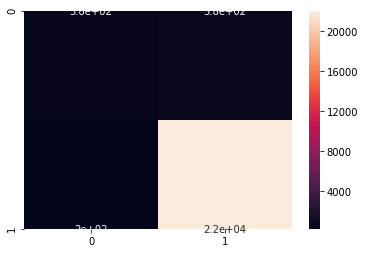

In [24]:
cmx = confusion_matrix(y_t, y_hat)
sns.heatmap(cmx, annot=True)

Despite updating a while ago this is still a problem, hmm...